In [ ]:
import pandas as pd
import ast
from collections import defaultdict
from tqdm.auto import tqdm, trange
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
filename = '../../data/amazon review 2018/Toys_and_Games_5_tagged5000.csv'
df = pd.read_csv(filename, index_col=0)

In [ ]:
df['all_num_word'] = df['all_num_word'].apply(ast.literal_eval)
df['all_upos'] = df['all_upos'].apply(ast.literal_eval)
df['all_xpos'] = df['all_xpos'].apply(ast.literal_eval)

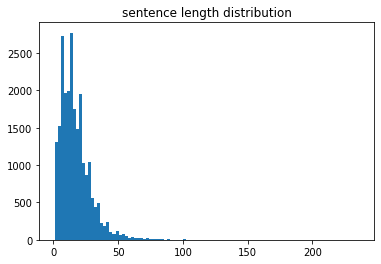

In [ ]:
sentence_length = [item for t in df['all_num_word'].tolist() for item in t]
plt.hist(sentence_length, bins=100)
plt.title('sentence length distribution')
plt.show()

# upos

In [ ]:
upos_tokens = ['none', # none is used in bigram and trigram for the beginning tokens
                 'ADJ',
                 'ADP',
                 'ADV',
                 'AUX',
                 'CCONJ',
                 'DET',
                 'INTJ',
                 'NOUN',
                 'NUM',
                 'PART',
                 'PRON',
                 'PROPN',
                 'PUNCT',
                 'SCONJ',
                 'SYM',
                 'VERB',
                 'X']
num_upos_tokens = len(upos_tokens)
upos_token2id = {upos_tokens[i]:i for i in range(num_upos_tokens)}

In [ ]:
def get_sent_pos_dist(sentence, token2id, normalize=True, return_list=False, trigram=True):
    if not isinstance(sentence[0], str):
        sentence = [token for sent in sentence for token in sent]
    num_tokens = len(token2id)
    unigram_pos = np.zeros(num_tokens)
    bigram_pos = np.zeros((num_tokens, num_tokens))
    if trigram:
        trigram_pos = np.zeros((num_tokens, num_tokens, num_tokens))

    pprev = 'none'
    prev = 'none'
    for token in sentence:
        unigram_pos[token2id[token]] += 1
        bigram_pos[token2id[prev]][token2id[token]] += 1
        if trigram:
            trigram_pos[token2id[pprev]][token2id[prev]][token2id[token]] += 1
        pprev = prev
        prev = token

    if normalize:
        unigram_pos = unigram_pos/unigram_pos.sum()
        bigram_pos = bigram_pos/bigram_pos.sum()
        if trigram:
            trigram_pos = trigram_pos/trigram_pos.sum()
        
    if return_list:
        if trigram:
            return unigram_pos.tolist(), bigram_pos.tolist(), trigram_pos.tolist()
        return unigram_pos.tolist(), bigram_pos.tolist()
    if trigram:    
        return unigram_pos, bigram_pos, trigram_pos    
    return unigram_pos, bigram_pos

## sentence level

In [ ]:
# to visualize the distribution over sentences.
unigram_dist = []
bigram_dist = []
trigram_dist = []
for doc in tqdm(df['all_upos']):
    for sentence in doc:
        unigram_pos, bigram_pos, trigram_pos = get_sent_pos_dist(sentence, upos_token2id, normalize=True, return_list=True)
        unigram_dist.append(unigram_pos)
        bigram_dist.append(bigram_pos)        
        trigram_dist.append(trigram_pos)        

  0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

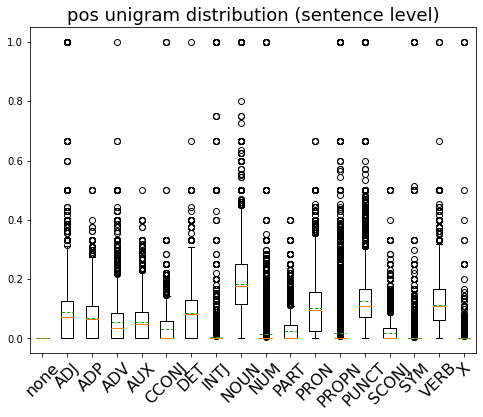

In [ ]:
plt.figure(figsize=(8,6))
plt.boxplot(np.array(unigram_dist), meanline=True, showmeans=True)
plt.xticks(np.arange(1,num_upos_tokens+1), upos_tokens, rotation=45, fontsize=16)
plt.title('pos unigram distribution (sentence level)', fontsize=18)
plt.show()

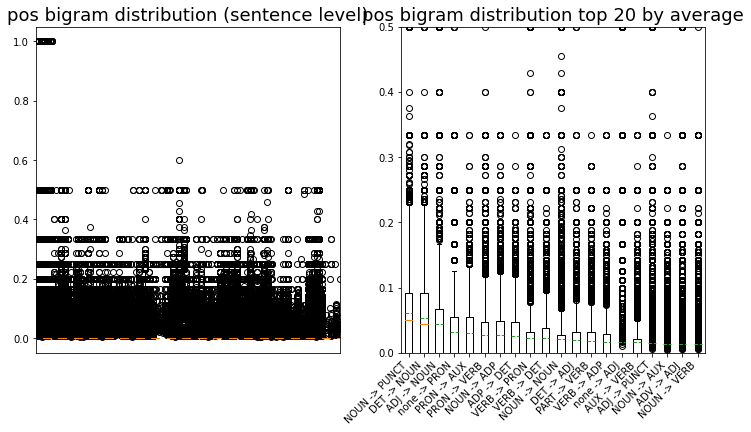

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
bigram_dist_reshaped = np.array(bigram_dist).reshape(len(bigram_dist),-1)
plt.boxplot(bigram_dist_reshaped)
curr, prev = np.meshgrid(upos_tokens, upos_tokens)
prev = prev.reshape(-1)
curr = curr.reshape(-1)
xticks = (pd.Series(prev) + " -> " + pd.Series(curr)).tolist()
# plt.xticks(np.arange(1,len(xticks)+1), xticks, rotation=45)
plt.xticks([])
plt.title('pos bigram distribution (sentence level)', fontsize=18)

plt.subplot(1,2,2)
top_n = 20
order = np.argsort(bigram_dist_reshaped.mean(axis=0))[::-1]
plt.boxplot(bigram_dist_reshaped[:,order[:top_n]], meanline=True, showmeans=True)
xticks = np.array(xticks)[order[:top_n]]
plt.xticks(np.arange(1,len(xticks)+1), xticks, rotation=45, ha='right')
plt.title(f'pos bigram distribution top {top_n} by average', fontsize=18)
plt.ylim(0,0.5)
plt.show()

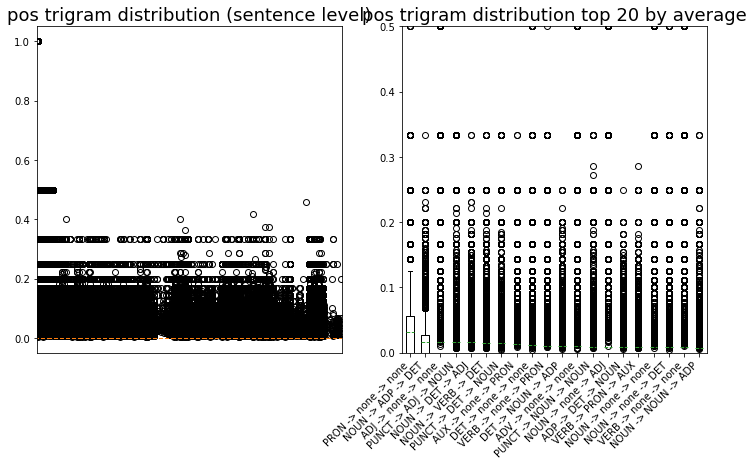

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
trigram_dist_reshaped = np.array(trigram_dist).reshape(len(trigram_dist), -1)
plt.boxplot(trigram_dist_reshaped)
curr, prev, pprev = np.meshgrid(upos_tokens, upos_tokens, upos_tokens)
pprev = pprev.reshape(-1)
prev = prev.reshape(-1)
curr = curr.reshape(-1)
xticks = (pd.Series(pprev) + " -> "+ pd.Series(prev) + " -> " + pd.Series(curr)).tolist()
# plt.xticks(np.arange(1,len(xticks)+1), xticks, rotation=45)
plt.xticks([])
plt.title('pos trigram distribution (sentence level)', fontsize=18)

plt.subplot(1,2,2)
top_n = 20
order = np.argsort(trigram_dist_reshaped.mean(axis=0))[::-1]
plt.boxplot(trigram_dist_reshaped[:,order[:top_n]], meanline=True, showmeans=True)
xticks = np.array(xticks)[order[:top_n]]
plt.xticks(np.arange(1,len(xticks)+1), xticks, rotation=45, ha='right')
plt.title(f'pos trigram distribution top {top_n} by average', fontsize=18)
plt.ylim(0,0.5)
plt.show()

## doc/paragraph level

In [ ]:
# to visualize the distribution over sentences.
unigram_dist = []
bigram_dist = []
trigram_dist = []
for doc in tqdm(df['all_upos']):
    unigram_pos, bigram_pos, trigram_pos = get_sent_pos_dist(doc, token2id, normalize=True, return_list=True)
    unigram_dist.append(unigram_pos)
    bigram_dist.append(bigram_pos)        
    trigram_dist.append(trigram_pos)        

  0%|          | 0/5000 [00:00<?, ?it/s]

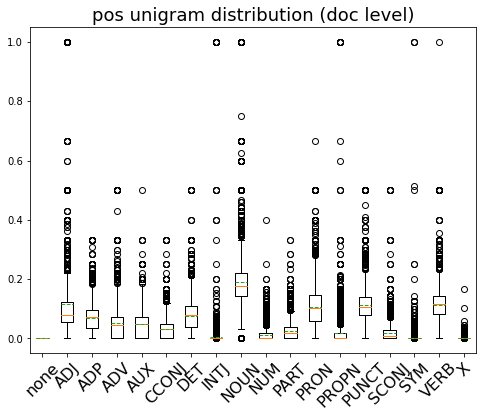

In [ ]:
plt.figure(figsize=(8,6))
plt.boxplot(np.array(unigram_dist), meanline=True, showmeans=True)
plt.xticks(np.arange(1,num_upos_tokens+1), upos_tokens, rotation=45, fontsize=16)
plt.title('pos unigram distribution (doc level)', fontsize=18)
plt.show()

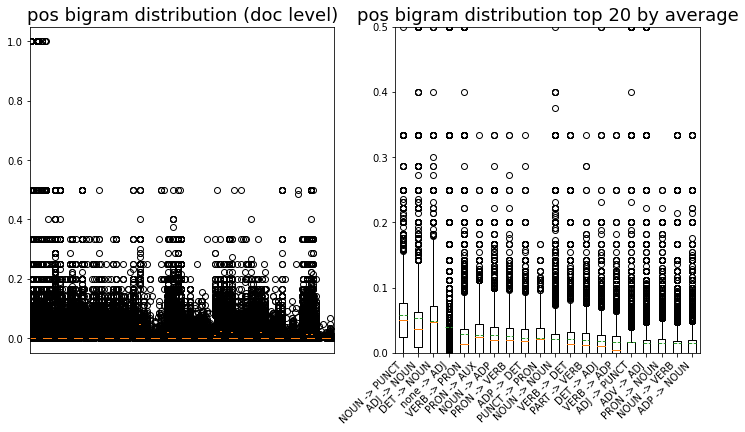

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
bigram_dist_reshaped = np.array(bigram_dist).reshape(len(bigram_dist),-1)
plt.boxplot(bigram_dist_reshaped)
curr, prev = np.meshgrid(upos_tokens, upos_tokens)
prev = prev.reshape(-1)
curr = curr.reshape(-1)
xticks = (pd.Series(prev) + " -> " + pd.Series(curr)).tolist()
# plt.xticks(np.arange(1,len(xticks)+1), xticks, rotation=45)
plt.xticks([])
plt.title('pos bigram distribution (doc level)', fontsize=18)

plt.subplot(1,2,2)
top_n = 20
order = np.argsort(bigram_dist_reshaped.mean(axis=0))[::-1]
plt.boxplot(bigram_dist_reshaped[:,order[:top_n]], meanline=True, showmeans=True)
xticks = np.array(xticks)[order[:top_n]]
plt.xticks(np.arange(1,len(xticks)+1), xticks, rotation=45, ha='right')
plt.title(f'pos bigram distribution top {top_n} by average', fontsize=18)
plt.ylim(0,0.5)
plt.show()

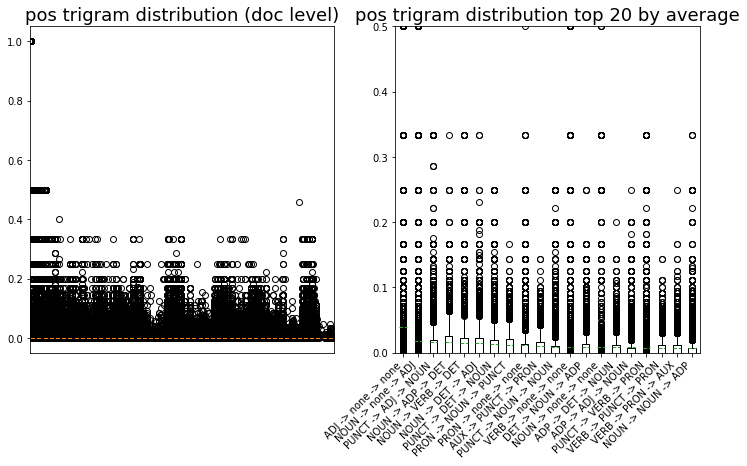

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
trigram_dist_reshaped = np.array(trigram_dist).reshape(len(trigram_dist), -1)
plt.boxplot(trigram_dist_reshaped)
curr, prev, pprev = np.meshgrid(upos_tokens, upos_tokens, upos_tokens)
pprev = pprev.reshape(-1)
prev = prev.reshape(-1)
curr = curr.reshape(-1)
xticks = (pd.Series(pprev) + " -> "+ pd.Series(prev) + " -> " + pd.Series(curr)).tolist()
# plt.xticks(np.arange(1,len(xticks)+1), xticks, rotation=45)
plt.xticks([])
plt.title('pos trigram distribution (doc level)', fontsize=18)

plt.subplot(1,2,2)
top_n = 20
order = np.argsort(trigram_dist_reshaped.mean(axis=0))[::-1]
plt.boxplot(trigram_dist_reshaped[:,order[:top_n]], meanline=True, showmeans=True)
xticks = np.array(xticks)[order[:top_n]]
plt.xticks(np.arange(1,len(xticks)+1), xticks, rotation=45, ha='right')
plt.title(f'pos trigram distribution top {top_n} by average', fontsize=18)
plt.ylim(0,0.5)
plt.show()

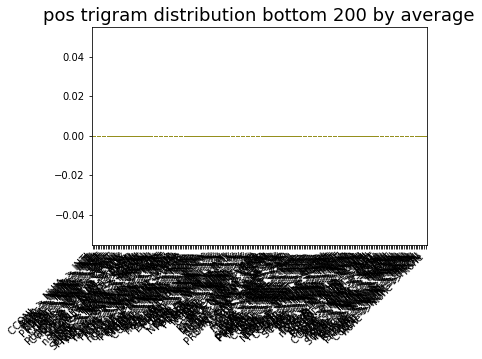

In [ ]:
top_n = 200
plt.boxplot(trigram_dist_reshaped[:,order[-top_n:]], meanline=True, showmeans=True)
xticks = (pd.Series(pprev) + " -> "+ pd.Series(prev) + " -> " + pd.Series(curr)).tolist()
xticks = np.array(xticks)[order[-top_n:]]
plt.xticks(np.arange(1,len(xticks)+1), xticks, rotation=45, ha='right')
plt.title(f'pos trigram distribution bottom {top_n} by average', fontsize=18)
# plt.ylim(0,0.5)
plt.show()

# xpos

In [ ]:
# nltk tagset has only 45
# from nltk.data import load
# tagdict = load('help/tagsets/upenn_tagset.pickle')

# xpos_vocab = list(tagdict.keys())
# xpos_vocab[xpos_vocab.index('(')] = '-LRB-'
# xpos_vocab[xpos_vocab.index(')')] = '-RRB-'
# xpos_vocab[xpos_vocab.index('--')] = 'HYPH'

In [ ]:
# https://emorynlp.github.io/nlp4j/components/part-of-speech-tagging.html
xpos_vocab = '''$ 	Dollar 	1.0.0
: 	Colon 	1.0.0
, 	Comma 	1.0.0
. 	Period 	1.0.0
`` 	Left quote 	1.0.0
'' 	Right quote 	1.0.0
-LRB- 	Left bracket 	1.0.0
-RRB- 	Right bracket 	1.0.0
ADD 	Email 	1.0.0
AFX 	Affix 	1.0.0
CC 	Coordinating conjunction 	1.0.0
CD 	Cardinal number 	1.0.0
DT 	Determiner 	1.0.0
EX 	Existential there 	1.0.0
FW 	Foreign word 	1.0.0
GW 	Go with 	1.0.0
HYPH 	Hyphen 	1.0.0
IN 	Preposition or subordinating conjunction 	1.0.0
JJ 	Adjective 	1.0.0
JJR 	Adjective, comparative 	1.0.0
JJS 	Adjective, superlative 	1.0.0
LS 	List item marker 	1.0.0
MD 	Modal 	1.0.0
NFP 	Superfluous punctuation 	1.0.0
NN 	Noun, singular or mass 	1.0.0
NNS 	Noun, plural 	1.0.0
NNP 	Proper noun, singular 	1.0.0
NNPS 	Proper noun, plural 	1.0.0
PDT 	Predeterminer 	1.0.0
POS 	Possessive ending 	1.0.0
PRP 	Personal pronoun 	1.0.0
PRP$ 	Possessive pronoun 	1.0.0
RB 	Adverb 	1.0.0
RBR 	Adverb, comparative 	1.0.0
RBS 	Adverb, superlative 	1.0.0
RP 	Particle 	1.0.0
SYM 	Symbol 	1.0.0
TO 	To 	1.0.0
UH 	Interjection 	1.0.0
VB 	Verb, base form 	1.0.0
VBD 	Verb, past tense 	1.0.0
VBG 	Verb, gerund or present participle 	1.0.0
VBN 	Verb, past participle 	1.0.0
VBP 	Verb, non-3rd person singular present 	1.0.0
VBZ 	Verb, 3rd person singular present 	1.0.0
WDT 	Wh-determiner 	1.0.0
WP 	Wh-pronoun 	1.0.0
WP$ 	Wh-pronoun, possessive 	1.0.0
WRB 	Wh-adverb 	1.0.0
XX'''.split('\n')
for i in range(len(xpos_vocab)):
    xpos_vocab[i] = xpos_vocab[i].split('\t')[0].strip()
xpos_vocab = ['none'] + xpos_vocab
num_xpos_tokens = len(xpos_vocab)
xpos_token2id = {xpos_vocab[i]:i for i in range(num_xpos_tokens)}

## sentence level

In [ ]:
# to visualize the distribution over sentences.
unigram_dist = []
bigram_dist = []
for doc in tqdm(df['all_xpos']):
    for sentence in doc:
        unigram_pos, bigram_pos = get_sent_pos_dist(sentence, xpos_token2id, normalize=True, return_list=True, trigram=False)
        unigram_dist.append(unigram_pos)
        bigram_dist.append(bigram_pos)        


  0%|          | 0/5000 [00:00<?, ?it/s]

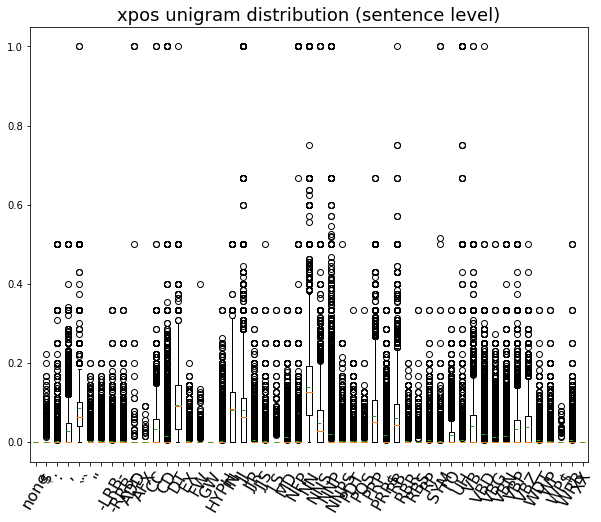

In [ ]:
plt.figure(figsize=(10,8))
plt.boxplot(np.array(unigram_dist), meanline=True, showmeans=True)
plt.xticks(np.arange(1,num_xpos_tokens+1), xpos_vocab, rotation=60, fontsize=16)
plt.title('xpos unigram distribution (sentence level)', fontsize=18)
plt.show()

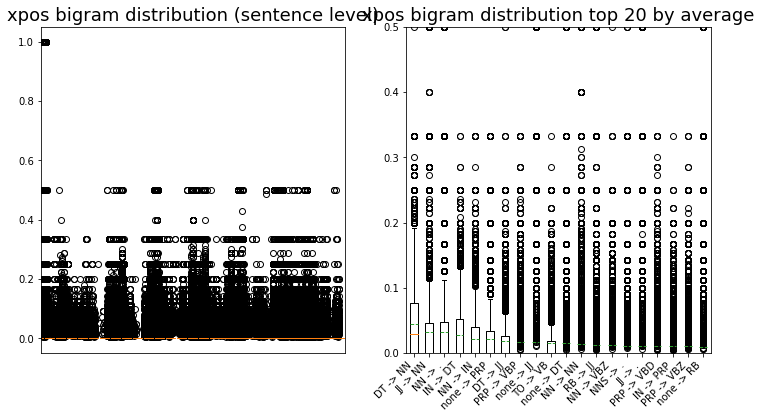

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
bigram_dist_reshaped = np.array(bigram_dist).reshape(len(bigram_dist),-1)
plt.boxplot(bigram_dist_reshaped)
curr, prev = np.meshgrid(xpos_vocab, xpos_vocab)
prev = prev.reshape(-1)
curr = curr.reshape(-1)
xticks = (pd.Series(prev) + " -> " + pd.Series(curr)).tolist()
# plt.xticks(np.arange(1,len(xticks)+1), xticks, rotation=45)
plt.xticks([])
plt.title('xpos bigram distribution (sentence level)', fontsize=18)

plt.subplot(1,2,2)
top_n = 20
order = np.argsort(bigram_dist_reshaped.mean(axis=0))[::-1]
plt.boxplot(bigram_dist_reshaped[:,order[:top_n]], meanline=True, showmeans=True)
xticks = np.array(xticks)[order[:top_n]]
plt.xticks(np.arange(1,len(xticks)+1), xticks, rotation=45, ha='right')
plt.title(f'xpos bigram distribution top {top_n} by average', fontsize=18)
plt.ylim(0,0.5)
plt.show()

## doc/paragraph level

In [ ]:
# to visualize the distribution over docs.
unigram_dist = []
bigram_dist = []
for doc in tqdm(df['all_xpos']):
    unigram_pos, bigram_pos = get_sent_pos_dist(doc, xpos_token2id, normalize=True, return_list=True, trigram=False)
    unigram_dist.append(unigram_pos)
    bigram_dist.append(bigram_pos)        


  0%|          | 0/5000 [00:00<?, ?it/s]

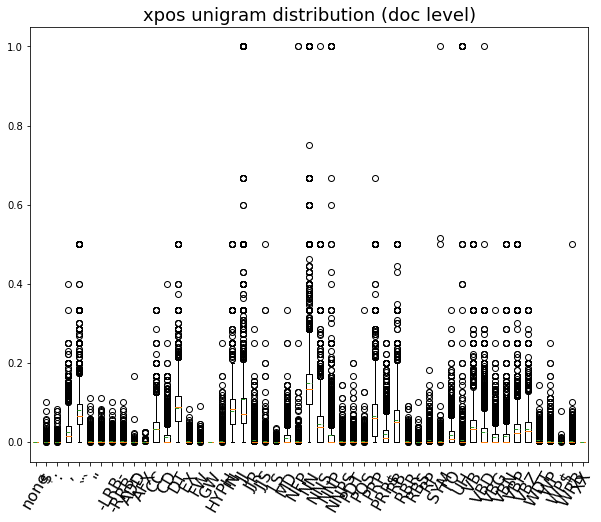

In [ ]:
plt.figure(figsize=(10,8))
plt.boxplot(np.array(unigram_dist), meanline=True, showmeans=True)
plt.xticks(np.arange(1,num_xpos_tokens+1), xpos_vocab, rotation=60, fontsize=16)
plt.title('xpos unigram distribution (doc level)', fontsize=18)
plt.show()

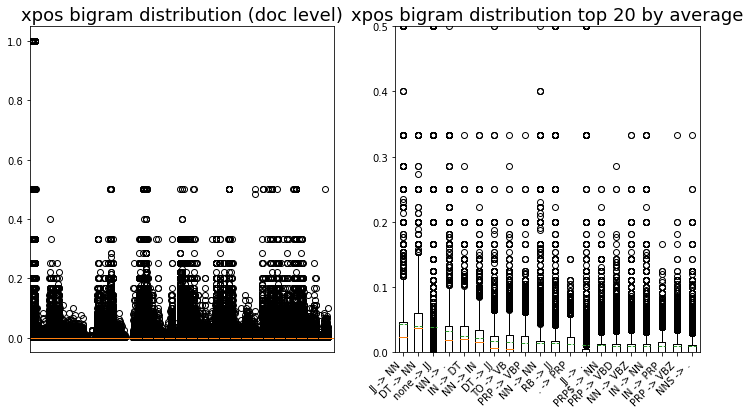

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
bigram_dist_reshaped = np.array(bigram_dist).reshape(len(bigram_dist),-1)
plt.boxplot(bigram_dist_reshaped)
curr, prev = np.meshgrid(xpos_vocab, xpos_vocab)
prev = prev.reshape(-1)
curr = curr.reshape(-1)
xticks = (pd.Series(prev) + " -> " + pd.Series(curr)).tolist()
# plt.xticks(np.arange(1,len(xticks)+1), xticks, rotation=45)
plt.xticks([])
plt.title('xpos bigram distribution (doc level)', fontsize=18)

plt.subplot(1,2,2)
top_n = 20
order = np.argsort(bigram_dist_reshaped.mean(axis=0))[::-1]
plt.boxplot(bigram_dist_reshaped[:,order[:top_n]], meanline=True, showmeans=True)
xticks = np.array(xticks)[order[:top_n]]
plt.xticks(np.arange(1,len(xticks)+1), xticks, rotation=45, ha='right')
plt.title(f'xpos bigram distribution top {top_n} by average', fontsize=18)
plt.ylim(0,0.5)
plt.show()

In [ ]:
curr, prev, pprev

(array(['none', 'none', 'none', ..., 'X', 'X', 'X'], dtype='<U5'),
 array(['none', 'none', 'none', ..., 'X', 'X', 'X'], dtype='<U5'),
 array(['none', 'ADJ', 'ADP', ..., 'SYM', 'VERB', 'X'], dtype='<U5'))

In [ ]:
# used to generate synthetic pos sequence.
unigram_dist = np.zeros(num_upos_tokens)
bigram_dist = np.zeros((num_upos_tokens, num_upos_tokens))
trigram_dist = np.zeros((num_upos_tokens, num_upos_tokens, num_upos_tokens))

for doc in tqdm(df['all_upos']):
    for sent in doc:
        pprev = 'none'
        prev = 'none'
        for token in sent:
            unigram_dist[upos_token2id[token]] += 1
            bigram_dist[upos_token2id[prev]][upos_token2id[token]] += 1
            trigram_dist[upos_token2id[pprev]][upos_token2id[prev]][upos_token2id[token]] += 1
            pprev = prev
            prev = token

  0%|          | 0/5000 [00:00<?, ?it/s]